C:\Users\mcthu\AppData\Local\Temp\ipykernel_31844\630802546.py:13: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  plt.plot(times[0:-1], cumtrapz(func(times))/total, label = "percent")
C:\Users\mcthu\AppData\Local\Temp\ipykernel_31844\630802546.py:14: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  stop = np.where(cumtrapz(func(times))/total < .99)
C:\Users\mcthu\AppData\Local\Temp\ipykernel_31844\630802546.py:15: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  plt.plot(times[stop][0:-1], cumtrapz(func(times[stop]))/total, label = "99.99 Percent")


stopped at 9.851218116019386e-06


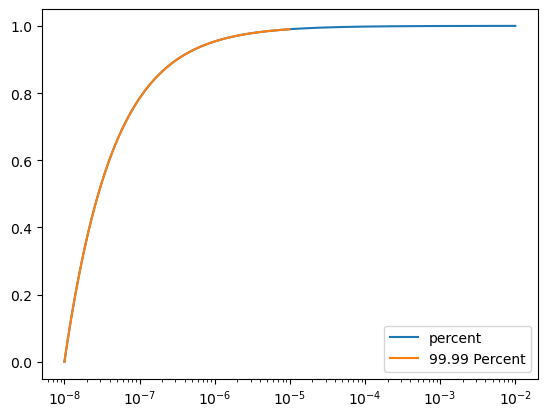

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz

from polished_scripts.MemoryTerm import rho_f


def func(t):
    return 1/(t)**(2/3)

times = np.logspace(-8,-2,100000)
total = np.trapz(func(times))
# plt.axhline(total, color='k')
# plt.plot(times,func(times))
# plt.plot(times[0:-1], cumtrapz(func(times)))
plt.plot(times[0:-1], cumtrapz(func(times))/total, label = "percent")
stop = np.where(cumtrapz(func(times))/total < .99)
plt.plot(times[stop][0:-1], cumtrapz(func(times[stop]))/total, label = "99.99 Percent")
plt.xscale('log')
plt.legend()
print("stopped at " + str(times[stop][-1]))
# plt.xlim(left=10**-7)
# plt.ylim(bottom=7e11)

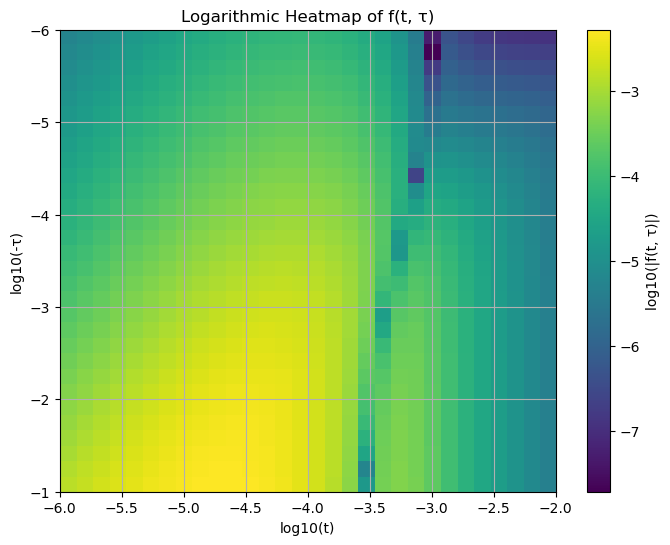

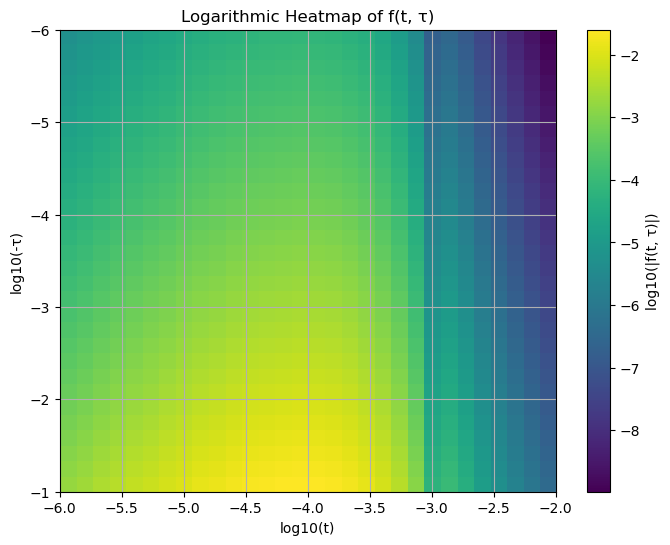

KeyboardInterrupt: 

In [5]:
import numpy as np
import mpmath as mp
from scipy.integrate import quad
import matplotlib.pyplot as plt

# Set mpmath precision for numerical inverse Laplace transform
mp.dps = 15

# Physical constants
radius = 2.639e-6
rho_f = 789
rho_p = 4200
eta = 0.36e-3
v_0 = 0.0003
mass = 4/3 * np.pi * radius**3 * rho_p + 2/3 * np.pi * radius**3 * rho_f

# Define the Laplace space function F(s, tau)
def F(s, tau):
    roots = [108.66994871+196.31569885j, 108.66994871-196.31569885j,
             -9.77032846 +66.56826441j,  -9.77032846 -66.56826441j]
    # Convert s and tau to mpmath for complex arithmetic
    s = mp.mpc(s)
    tau = mp.mpf(tau)
    # Compute denominator D
    D = (roots[0] + mp.sqrt(s)) * (roots[1] + mp.sqrt(s)) * (roots[2] + mp.sqrt(s)) * (roots[3] + mp.sqrt(s))
    # Compute numerator for negative tau
    inv =  2/mp.sqrt(-tau) - 2 * (mp.exp(-tau*s) * mp.sqrt(s) * mp.sqrt(mp.pi) * mp.erfc(mp.sqrt(-tau*s)))
    return inv / D

def F2(s, tau):
    roots = [108.66994871+196.31569885j, 108.66994871-196.31569885j,
             -9.77032846 +66.56826441j,  -9.77032846 -66.56826441j]
    # Convert s and tau to mpmath for complex arithmetic
    s = mp.mpc(s)
    tau = mp.mpf(tau)
    # Compute denominator D
    D = (roots[0] + mp.sqrt(s)) * (roots[1] + mp.sqrt(s)) * (roots[2] + mp.sqrt(s)) * (roots[3] + mp.sqrt(s))
    # Compute numerator for negative tau
    inv = 2/mp.sqrt(-tau)
    return inv / D

# Define the multiplier function h(tau)
def h(tau):
    prefactor = 6 * radius**2 * np.sqrt(np.pi * rho_f * eta) * (1/mass)
    return prefactor * v_0

# Define the inverse Laplace transform f(t, tau)
def f(t, tau):
    # Wrap F(s, tau) for mpmath's invertlaplace
    def F_s(s):
        return F(s, tau)
    # Compute numerical inverse Laplace transform using Talbot method
    result = mp.invertlaplace(F_s, t, method='talbot')
    # Convert to float, handling small imaginary parts
    return float(mp.re(result))

# Define the inverse Laplace transform f(t, tau)
def f2(t, tau):
    # Wrap F(s, tau) for mpmath's invertlaplace
    def F_s(s):
        return F2(s, tau)
    # Compute numerical inverse Laplace transform using Talbot method
    result = mp.invertlaplace(F_s, t, method='talbot')
    # Convert to float, handling small imaginary parts
    return float(mp.re(result))

# Define the integrand g(t, tau) = f(t, tau) * h(tau)
def g(t, tau):
    return f(t, tau) * h(tau)

# Compute the final function u(t) by integrating over tau
def u(t):
    # Integrate from tauMax to tauMin (since -1e-6 > -1e-4)
    result, _ = quad(lambda tau: g(t, tau), tauMax, tauMin, epsabs=1e-10, epsrel=1e-10)
    return result

# Define ranges for t and tau
tMin = 1e-6
tMax = 1e-2
tauMin = -1e-1  # Negative tau
tauMax = -1e-6  # Negative tau, larger value

# Create logarithmic grid for visualization of f(t, tau)
nPoints = 30  # Grid size (30x30)
tGrid = np.logspace(np.log10(tMin), np.log10(tMax), nPoints)
# Logarithmic spacing for negative tau: use positive magnitudes and negate
tauGrid = -np.logspace(np.log10(-tauMin), np.log10(-tauMax), nPoints)[::-1]  # Reverse to go from -1e-6 to -1e-4
T, Tau = np.meshgrid(tGrid, tauGrid)

# # Compute f(t, tau) on the grid
# fGrid = np.vectorize(f)(T, Tau)
#
# # Compute f(t, tau) on the grid
# f2Grid = np.vectorize(f2)(T, Tau)
#
# # Create heatmap for f(t, tau) with logarithmic color scale
# plt.figure(figsize=(8, 6))
# plt.imshow(np.log10(np.abs(fGrid + 1e-10)), origin='lower',
#            extent=[np.log10(tMin), np.log10(tMax), np.log10(-tauMin), np.log10(-tauMax)],
#            cmap='viridis', aspect='auto')
# plt.colorbar(label='log10(|f(t, τ)|)')
# plt.xlabel('log10(t)')
# plt.ylabel('log10(-τ)')
# plt.title('Logarithmic Heatmap of f(t, τ)')
# plt.grid(True)
# plt.show()
# # Create heatmap for f(t, tau) with logarithmic color scale
# plt.figure(figsize=(8, 6))
# plt.imshow(np.log10(np.abs(f2Grid + 1e-10)), origin='lower',
#            extent=[np.log10(tMin), np.log10(tMax), np.log10(-tauMin), np.log10(-tauMax)],
#            cmap='viridis', aspect='auto')
# plt.colorbar(label='log10(|f(t, τ)|)')
# plt.xlabel('log10(t)')
# plt.ylabel('log10(-τ)')
# plt.title('Logarithmic Heatmap of f(t, τ)')
# plt.grid(True)
# plt.show()

# Compute u(t) for plotting
tPoints = np.logspace(np.log10(tMin), np.log10(tMax), 100)  # Logarithmic t-points
uValues = [u(t) for t in tPoints]

# Plot u(t) with logarithmic t-axis
plt.figure(figsize=(8, 6))
plt.semilogx(tPoints, uValues, '-b', label='u(t)')
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title('Final Function u(t)')
plt.grid(True)
plt.legend()
plt.show()